In [6]:
from __future__ import annotations

from typing import Any

from gnn_tracking.models.track_condensation_networks import PerfectECGraphTCN
from gnn_tracking.training.dynamiclossweights import NormalizeAt
from gnn_tracking.utils.dictionaries import subdict_with_prefix_stripped
from torch import nn

import numpy as np
from celluloid import Camera

from gnn_tracking_hpo.config import auto_suggest_if_not_fixed, get_metadata
from gnn_tracking_hpo.trainable import TCNTrainable, suggest_default_values

In [7]:
class DynamicTCNTrainable(TCNTrainable):
    def get_loss_functions(self) -> dict[str, Any]:
        return {
            "potential": self.get_potential_loss_function(),
            "background": self.get_background_loss_function(),
        }

    def get_cluster_functions(self) -> dict[str, Any]:
        return {}

    def get_loss_weights(self):
        relative_weights = [
            {},
            subdict_with_prefix_stripped(self.tc, "rlw_"),
        ]
        return NormalizeAt(
            at=[0, 1],
            relative_weights=relative_weights,
        )

    def get_model(self) -> nn.Module:
        return PerfectECGraphTCN(
            node_indim=6, edge_indim=4, **subdict_with_prefix_stripped(self.tc, "m_"),
        )
        pass


In [8]:
def get_config(
) -> dict[str, Any]:
    config = get_metadata()

    def d(key, *args, **kwargs):
        auto_suggest_if_not_fixed(key, config, None, *args, **kwargs)

    d("sector", 9)
    d("n_graphs_train", 20)
    d("n_graphs_val", 10)
    d("n_graphs_test", 1)
    d("training_pt_thld", 0.3)
    d("training_without_noise", False)
    d("batch_size", 1)
    d("m_h_outdim", 2)
    d("m_ec_tnr", 1)
    d("m_ec_tpr", 0.6)


    suggest_default_values(config, None, perfect_ec=True)
    return config

In [9]:
config = get_config()

In [67]:
from gnn_tracking.training.tcn_trainer import TCNTrainer
from torch_geometric.data import Data


class FixedDataLatentSpacePlotCollector:
    def __init__(self, data: Data, apply_truth_cuts=True):
        """This hook for collecting data for latent space animations
        is the most precise/detailed one, because it evaluates one
        graph after every single batch.
        The downside: It slows down training significantly because it
        doubles the evaluations that need to be done.

        Args:
            data:
            apply_truth_cuts:
        """
        self.latent_spaces = []
        self.latent_epoch = []
        self.latent_batch_index = []
        self.data = data
        self.apply_truth_cuts = apply_truth_cuts

    @staticmethod
    def should_snapshot(epoch: int, batch_index: int) -> bool:
        """Implement this to avoid performance degradation by
        only taking snapshot every nth epoch/batch
        """
        return True

    def __call__(self, trainer: TCNTrainer, epoch: int, batch_index: int, model_output: int, data: Data):
        if not self.should_snapshot(epoch, batch_index):
            return
        test_model_output = trainer.evaluate_model(self.data, apply_truth_cuts=self.apply_truth_cuts)
        self.latent_spaces.append(test_model_output["x"].detach().numpy())
        self.latent_epoch.append(epoch)
        self.latent_batch_index.append(batch_index)

In [21]:
trainable = DynamicTCNTrainable(config)
trainer = trainable.trainer

DEBUG: Got config
{'attr_pt_thld': 0.9,
 'batch_size': 1,
 'gnn_tracking_experiments_hash': 'efed91462fea5b9ef534ef30dc6d21ee7188bf18',
 'gnn_tracking_hash': '299adb94b814860c454c255a503a512f510f40cb',
 'lr': 0.0005,
 'm_L_hc': 3,
 'm_alpha_hc': 0.5,
 'm_e_dim': 4,
 'm_ec_tnr': 1,
 'm_ec_tpr': 0.6,
 'm_h_dim': 5,
 'm_h_outdim': 2,
 'm_hidden_dim': 40,
 'n_graphs_test': 1,
 'n_graphs_train': 20,
 'n_graphs_val': 10,
 'optimizer': 'adam',
 'q_min': 0.01,
 'sb': 0.1,
 'scheduler': None,
 'sector': 9,
 'test': False,
 'training_pt_thld': 0.3,
 'training_without_noise': False}
INFO: Loading data to cpu memory
INFO: Loading 31 graphs (out of 371 available).
DEBUG: Parameters for data loaders: {'batch_size': 1, 'num_workers': 12}
INFO: Using device cpu


In [22]:
import torch
trainer = trainable.trainer
sel = 5

with torch.no_grad():
    loader = trainer.val_loader
    for idx, data in enumerate(loader):
        if idx < sel:
            continue
        # model_output = trainer.evaluate_model(data, mask_pids_reco=False)
        if idx == sel:
            break

test_data_point = data

In [23]:
collector = FixedDataLatentSpacePlotCollector(data)
trainer.add_hook(collector, "batch")

In [64]:
trainer.test_step = lambda *args, **kwargs: {}

In [65]:
for i in range(15):
    trainable.step()

INFO: Epoch 14 (    0/20): background_weighted=   1.09291, potential_attractive_weighted=   0.00066, potential_repulsive_weighted=   0.59107
INFO: Epoch 14 (   10/20): background_weighted=   1.09832, potential_attractive_weighted=   0.00076, potential_repulsive_weighted=   0.62400
INFO: Training for epoch 14 took 2.16 seconds
INFO: Test step for epoch 14 took 0.00 seconds
INFO: Results 14: 
+----+-------------------------------------+-----------+
|    | Metric                              |     Value |
+====+=====================================+===========+
|    | background_train                    |   0.58573 |
|    | background_weighted_train           |   1.09821 |
|    | potential_attractive_train          |   0.00000 |
|    | potential_attractive_weighted_train |   0.00075 |
|    | potential_repulsive_train           | 169.25667 |
|    | potential_repulsive_weighted_train  |   0.54591 |
|    | total_train                         |   1.64488 |
+----+------------------------------

In [51]:
def get_color_mapper(selected_values, colors: Sequence|None=None):
    if colors is None:
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    if len(selected_values) > len(colors):
        raise ValueError(f"Only up to {len(colors)} values can be selected.")

    cm = np.vectorize(colors.__getitem__)
    vm = np.vectorize({p.item(): i for i, p in enumerate(selected_values)}.get)

    def mapper(values):
        mv = vm(values)
        print(mv, colors)
        return cm(mv)

    return mapper

In [52]:
selected_pids = np.random.choice(collector.data.particle_id[collector.data.pt > 1 & collector.data.reconstructable], 10)
cm = get_color_mapper(selected_pids)

In [54]:
cm(selected_pids[0])

0 ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


array('#1f77b4', dtype='<U7')

[5 5 5 5 3 5 3 5 5 3 5 3 5 5 3 5 2 4 3 3 2 4 2 4 2 4 4 6 6 9 1 6 0 6 9 9 1
 6 9 1 6 9 0 1 9 1 9 1 6 6 9 1 0 0 1 6 9 1 6 9 1 0 0 1 9 9 6 0 0 1 9 9] ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


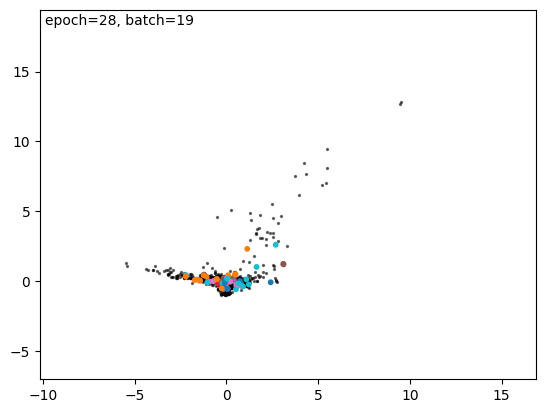

In [66]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
camera = Camera(fig)
tqdm = lambda x: x
# todo: add if statement here
truth_cut_pids = collector.data.particle_id[trainer._get_training_mask(collector.data)[0]]
selected_mask = np.isin(truth_cut_pids.numpy(), selected_pids)
colors = cm(truth_cut_pids[np.isin(truth_cut_pids.numpy(), selected_pids)])
for latent, epoch, batch in tqdm(zip(collector.latent_spaces, collector.latent_epoch, collector.latent_batch_index)):
    mu = np.mean(latent, axis=0)
    std = np.std(latent, axis=0)
    latent -= mu
    latent /= std
    label = f"epoch={epoch}, batch={batch}"
    ax.scatter(latent[~selected_mask][:, 0], latent[~selected_mask][:, 1], s=2, color="black", alpha=0.5)
    ax.scatter(latent[selected_mask][:, 0], latent[selected_mask][:, 1], s=10, color=colors, alpha=1)
    ax.text(.01, .99, label, ha='left', va='top', transform=ax.transAxes)
    camera.snap()
anim = camera.animate(blit=True, interval=80)
anim.save('scatter.mp4')

In [179]:
from matplotlib import animation


class AnimatedScatterLatent(object):
    def __init__(self, data):
        """An animated scatter plot using matplotlib.animations.FuncAnimation."""
        self.data = data
        self.fig, self.ax = plt.subplots()
        self.ani = animation.FuncAnimation(
            self.fig,
            self.update,
            interval=5,
            frames=self.data,
            init_func=self.setup_plot,
            blit=False,
        )

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        self.scat = self.ax.scatter(self.data[0][:, 0], self.data[0][:, 1])
        return self.scat,

    def update(self, data):
        """Update the scatter plot."""
        self.scat.set_offsets(data)
        self.ax.relim()
        self.ax.autoscale_view()
        return scat,


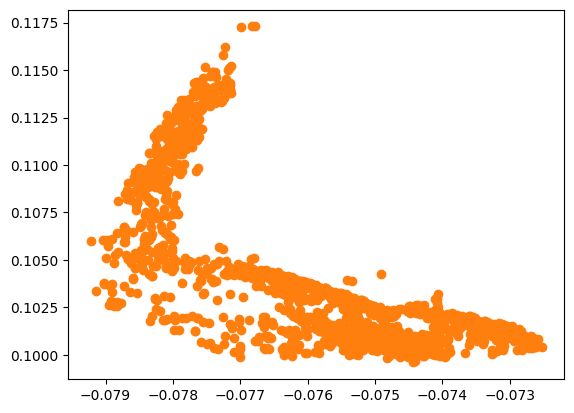

In [180]:
da = AnimatedScatterLatent(trainer.latent_spaces)
FFwriter = animation.FFMpegWriter(fps=10)
da.ani.save('scatter2.mp4', writer = FFwriter)

In [ ]:


x = model_output["x"]

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x[:, 0], x[:, 1], s=2)